In [1]:
# Source/Reference: https://www.tensorflow.org/tutorials/structured_data/time_series

## Time Series Forecasting using-LSTM

### Importing important libraries.

In [2]:
import tensorflow as tf 
import matplotlib as mpl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Global parameter for all matplot-lib plots
mpl.rcParams['figure.figsize'] = (12,6)
mpl.rcParams['axes.grid'] = False

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset 

In [5]:
# data source: Max Plank Institute, https://www.bgc-jena.mpg.de/wetter/

zip_path = tf.keras.utils.get_file( # 
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

13568290/13568290 [==============================] - 2s 0us/step


In [6]:
print(zip_path)

/root/.keras/datasets/jena_climate_2009_2016.csv.zip


In [7]:
import os

csv_path, _ = os.path.splitext(zip_path) # https://docs.python.org/3/library/os.path.html


In [8]:
! ls /root/.keras/datasets/

jena_climate_2009_2016.csv  jena_climate_2009_2016.csv.zip


In [9]:
df = pd.read_csv(csv_path)
df.head(3)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6


### Observation from the dataset:
1. One reading every 10 min.
2. 1 day  = 6*24 = 144reading (6 reading per hour)
3. 5 days = 144*5 = 720 readings.

## Univariate Analysis:

### FORECASTING TASK: Predict Temperature (in deg.) in the future.

#### univariate: temperature vs time
#### using moving average windows

In [10]:
uni_data_df = df['T (degC)']
uni_data_df.index = df['Date Time']
uni_data_df.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

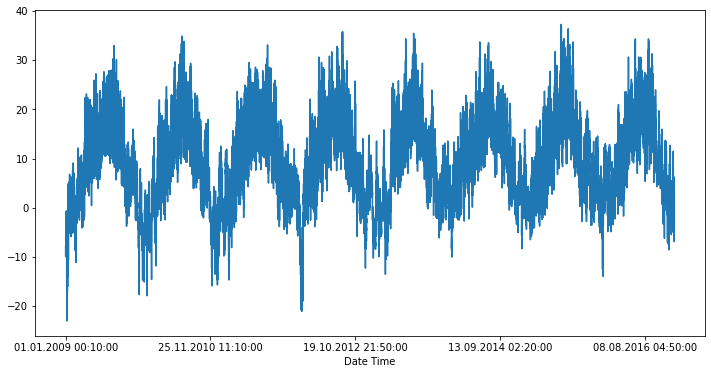

In [11]:
uni_data_df.plot()

In [12]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.values.html

uni_data = uni_data_df.values # df.values convert pandas into numpy array
uni_data.shape

(420551,)

#### total number of record is : 420551
#### split the data into two part for test and train on temporal basis
#### train data is __300000__ and test data is __120551__

In [13]:
train_split = 300000; # 300,000 is approx 2100 days

tf.random.set_seed(42)

# Normalised the data: Mean centering and variance-scaling
# Note: In order to prevent the leakage we use only train data to normalise the whole data both train and test

mean_value = uni_data[:train_split].mean()
std_value = uni_data[:train_split].std()

uni_data = (uni_data-mean_value)/std_value
print(type(uni_data))
print(uni_data)

<class 'numpy.ndarray'>
[-1.99766294 -2.04281897 -2.05439744 ... -1.43494935 -1.55883897
 -1.62715193]


## Moving Window Average:

### pose a simple problem:
Given last 'k' values of temp-obeservation(univariate), predict the next observation

### MWA: Average the previous 'k' values to predict the nxt value.

In [14]:
# This function creates the data we need for the above problem
# dataset: numpy ndarray
# start_index: start of the data points
# end_index: end point of data set
# history_size: k => take k values at a time
# target_size: 0 => next value in the time-series
# Output: data: (n,k) and labels (n,1)

def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index+history_size
    if (end_index is None):
        end_index = len(dataset)-target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i) # this will extract 20 data points from dataset
    # append the extracted data to data and reshape into (history_size,1)
    # 1 bcz we want to predict one value at a time

        data.append(np.reshape(dataset[indices], (history_size, 1)))

        labels.append(dataset[i+target_size])

    return np.array(data), np.array(labels)


In [15]:
# use this function to generate data for lstm model

univariate_history = 20;
univariate_target = 0

X_train, y_train = univariate_data(uni_data, 0, train_split, univariate_history, univariate_target)
X_val, y_val = univariate_data(uni_data, train_split, None,  univariate_history, univariate_target)


print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(299980, 20, 1) (299980,)
(120531, 20, 1) (120531,)


In [16]:
# single window of past history
print("Printing the single window of past history: " ,X_train[0])
print("printing the target temperature: ", y_train[0])

Printing the single window of past history:  [[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]
printing the target temperature:  -2.1041848598100876


In [17]:
# creating the time-steps 
def create_timeSteps(length):
    return list(range(-length,0))

print(create_timeSteps(20))

[-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


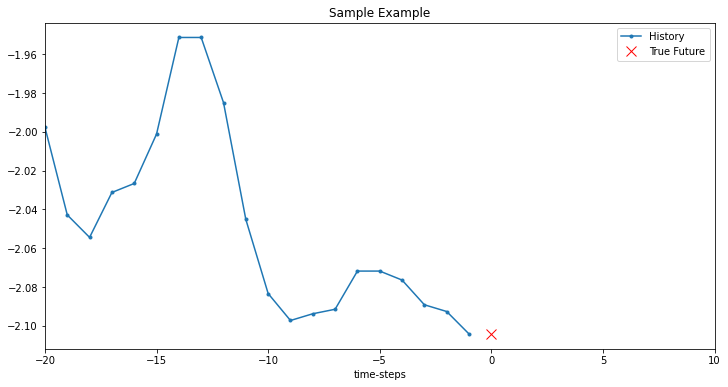

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [18]:
# plotting function

# plot data = contains list of data and target value
# delta: 0=>  next time steps given last 'k'
# title = plot title
# refer: https://matplotlib.org/3.1.1/api/markers_api.html

def show_plot(plot_data, delta, title):

    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go'] #  dot-line, red-x and green-o

    timeSteps = create_timeSteps(plot_data[0].shape[0])

    if delta:
        future = delta
    else:
        future = 0 # this will plot on x-axis for target value

    plt.title(title)

    for i,x in enumerate(plot_data): # list of items X_train, and y_train
        if i: # i = 0 or 1
            plt.plot(future, plot_data[i], marker[i],markersize=10,label=labels[i] ) # plot the target value
        else:
            plt.plot(timeSteps, plot_data[i].flatten(), marker[i], label=labels[i]) # plot the k-past-history
    plt.legend()
    plt.xlim([timeSteps[0], (future+5)*2]) # range of x coordinates
    plt.xlabel("time-steps")
    plt.show()

    return plt

show_plot([X_train[0], y_train[0]], 0, 'Sample Example')



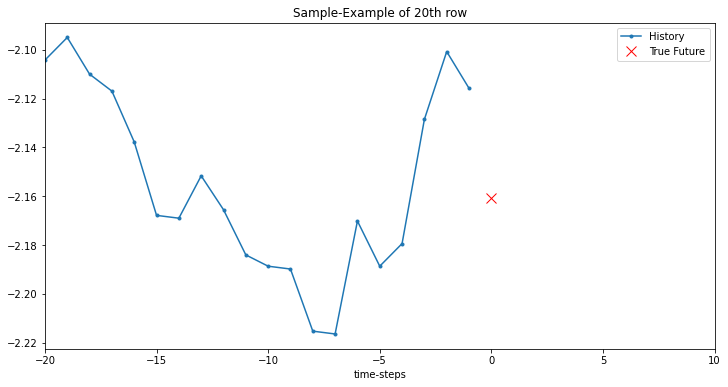

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [19]:
# for any row of data
i = 20;
show_plot([X_train[i], y_train[i]], 0, 'Sample-Example of 20th row')

In [20]:
# lets define the moving window average 
def mwa(history):
    return np.mean(history)


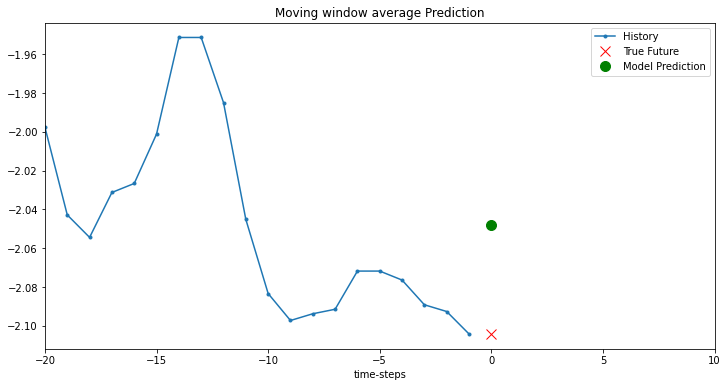

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [21]:
i = 0;
show_plot([X_train[i], y_train[i], mwa(X_train[i])], 0, 'Moving window average Prediction' )

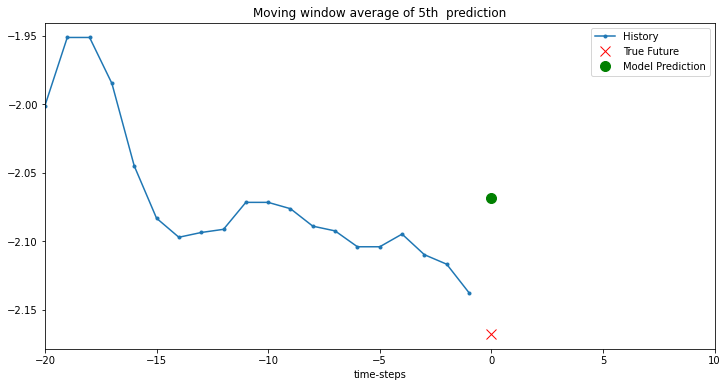

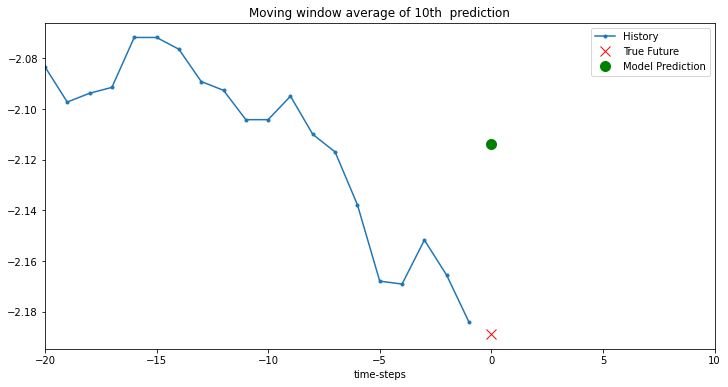

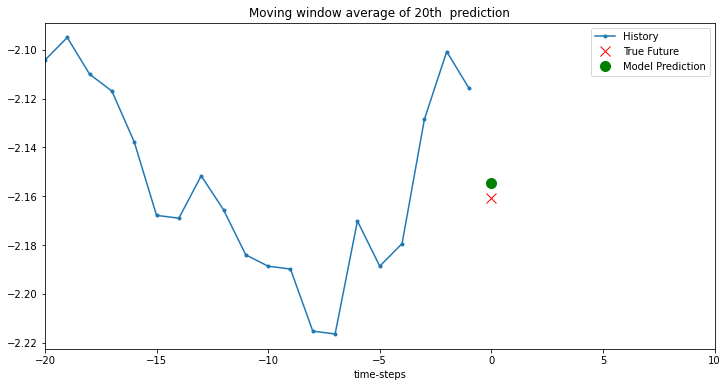

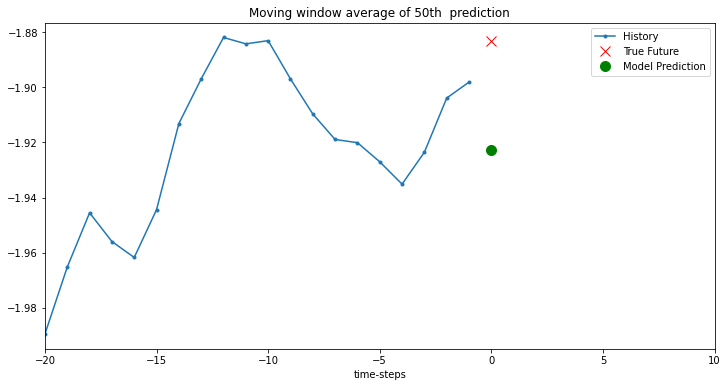

In [22]:
rows = [5, 10, 20, 50]
for i in rows:
    show_plot([X_train[i], y_train[i], mwa(X_train[i])], 0, "Moving window average of "+str(i)+'th  prediction')

### Observation:
Moving window average results:  Out the four prediction made by mwa only one was very close.

This means moving window average is not a good model here:

# Univariate Using LSTM model:

In [23]:
batch_size = 256; # batch size in sgd
buffer_size = 10000  # #https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat

# https://www.tensorflow.org/api_docs/python/tf/data/experimental/shuffle_and_repeat

# convert the dataset into tensorflow data set

train_univariate =tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_univariate = train_univariate.cache().shuffle(buffer_size).batch(batch_size).repeat()

# for validation dataset
val_univariate = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_univariate = val_univariate.batch(batch_size).repeat()

In [24]:
print(train_univariate)
print(val_univariate)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [25]:
# simplest model
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=X_train.shape[-2:]),tf.keras.layers.Dense(1) ])   # shape = (20,1)

simple_lstm_model.compile(optimizer = 'adam', loss = 'mae')

In [26]:
simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [27]:
Steps_per_epoch = 200;
Epochs =10

simple_lstm_model.fit(train_univariate, epochs =Epochs,
                      steps_per_epoch = Steps_per_epoch, 
                      validation_data = val_univariate,
                      validation_steps = 50
                      )

Epoch 1/10
200/200 [==============================] - 10s 7ms/step - loss: 0.3429 - val_loss: 0.0543
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0754 - val_loss: 0.0268
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0393 - val_loss: 0.0222
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0383 - val_loss: 0.0198
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0239 - val_loss: 0.0185
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0256 - val_loss: 0.0172
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0236 - val_loss: 0.0163
Epoch 8/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0219 - val_loss: 0.0156
Epoch 9/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0210 - val_loss: 0.0146
Epoch 10/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0196 - val_loss: 0.014

8/8 [==============================] - 0s 2ms/step


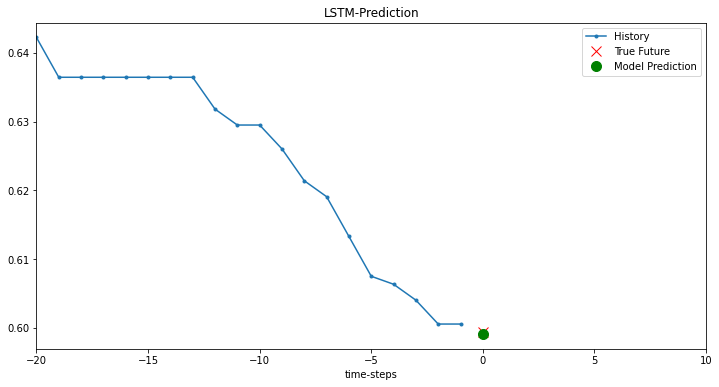

8/8 [==============================] - 0s 2ms/step


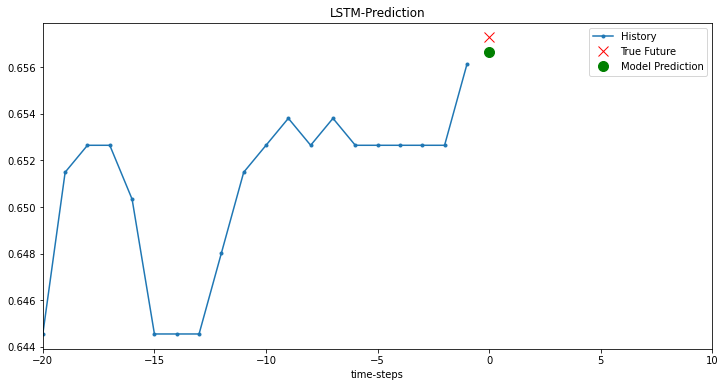

8/8 [==============================] - 0s 2ms/step


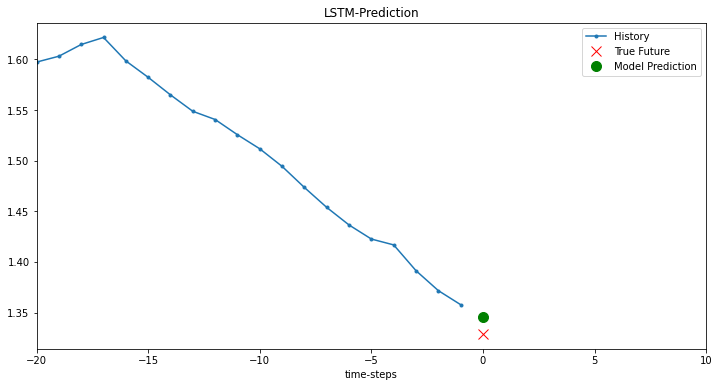

8/8 [==============================] - 0s 2ms/step


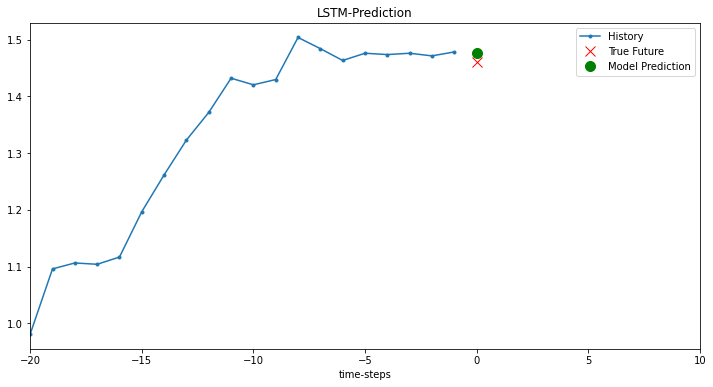

8/8 [==============================] - 0s 2ms/step


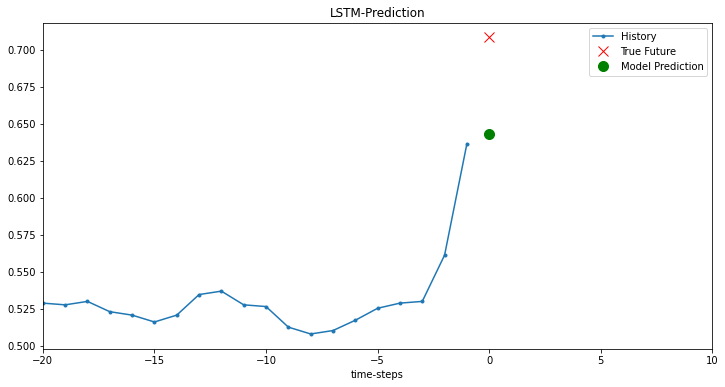

In [28]:
for x, y in val_univariate.take(5):  # this will take 5 random value from val_univariate
    plot = show_plot([x[0].numpy(),y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'LSTM-Prediction')
plot.show()

In [29]:
original = []
predicted = []

for x,y in val_univariate.take(10):
    original.append(y[0].numpy())
    predicted.append(list(simple_lstm_model.predict(x)[0]))
print(original)
print(predicted) 

8/8 [==============================] - 0s 2ms/step
[0.5993876681669458, 0.657280013519773, 1.3288312196125696, 1.4608257670170157, 0.708225277430261, 0.18835201616187214, 0.010043592475164238, 0.2786640749122828, -0.14742358688452598, 0.8691659975111207]
[[0.59910077], [0.65664405], [1.3452806], [1.4762881], [0.64317346], [0.18205044], [0.008633181], [0.284526], [-0.1474343], [0.8675136]]


__LSTM-Model prediction is much more accurate than moving windows average:__

# Multi-variate and single-step forecasting:

In [30]:
# lets consider the features are : pressure, temperature and rho

features_considered = ['p (mbar)', 'T (degC)','rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ccffc5f90>,
      dtype=object)

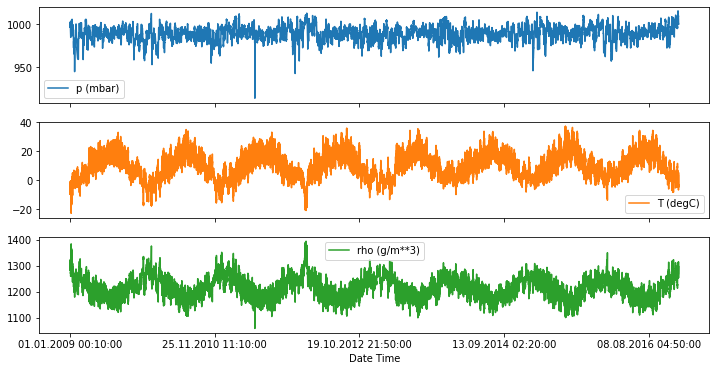

In [31]:
features.plot(subplots = True)

__From the above plot we can infer that there is direct relation between temperature and rho value, as can be seen when rho value is up temp is down and vice-varsa__

In [45]:
dataset = features.values
data_mean = dataset[:train_split].mean(axis=0)
data_std = dataset[:train_split].std(axis=0)
dataset = (dataset-data_mean)/data_std

dataset

array([[ 0.95547359, -1.99766294,  2.2350791 ],
       [ 0.96154485, -2.04281897,  2.28524007],
       [ 0.95668784, -2.05439744,  2.29600633],
       ...,
       [ 1.35617678, -1.43494935,  1.76136375],
       [ 1.35496252, -1.55883897,  1.88786728],
       [ 1.35617678, -1.62715193,  1.95686921]])

In [46]:
# Here we have data for every 10 min but in this short time frame 
#temperature is not much changed so generate data for every 60 min

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step) # step used here.
    data.append(dataset[indices])

    if single_step: # single_step used here.
      labels.append(target[i+target_size]) 
    else:
      labels.append(target[i:i+target_size]) 

  return np.array(data), np.array(labels)


In [50]:
# generate data
past_history = 720;
future_target = 72;

X_train_single, y_train_single = multivariate_data(dataset, dataset[:,1], 0, train_split,past_history, future_target, 6, single_step=True)
X_val_single, y_val_single = multivariate_data(dataset, dataset[:,1], train_split, None, past_history, future_target, 6, single_step=True)


In [51]:
print(X_train_single.shape)
print(y_train_single.shape)

(299280, 120, 3)
(299280,)


In [52]:
# convert this data into tensor data types
train_data_single = tf.data.Dataset.from_tensor_slices((X_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((X_val_single, y_val_single))
val_data_single = val_data_single.batch(batch_size).repeat()

print(train_data_single)
print(val_data_single)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [55]:
# now built the model # simplest model with only lstm and one dense layer

single_steps_model = tf.keras.models.Sequential()
single_steps_model.add(tf.keras.layers.LSTM(32, input_shape=X_train_single.shape[-2:]))

single_steps_model.add(tf.keras.layers.Dense(1))
single_steps_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')




single_steps_history = single_steps_model.fit(train_data_single, epochs=Epochs, steps_per_epoch=Steps_per_epoch,
                                              validation_data = val_data_single, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 5s 14ms/step - loss: 0.3063 - val_loss: 0.2490
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2594 - val_loss: 0.2408
Epoch 3/10
200/200 [==============================] - 3s 17ms/step - loss: 0.2590 - val_loss: 0.2437
Epoch 4/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2566 - val_loss: 0.2371
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2241 - val_loss: 0.2406
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2385 - val_loss: 0.2564
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2422 - val_loss: 0.2577
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2392 - val_loss: 0.2570
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2444 - val_loss: 0.2566
Epoch 10/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2407 - val_loss: 0.

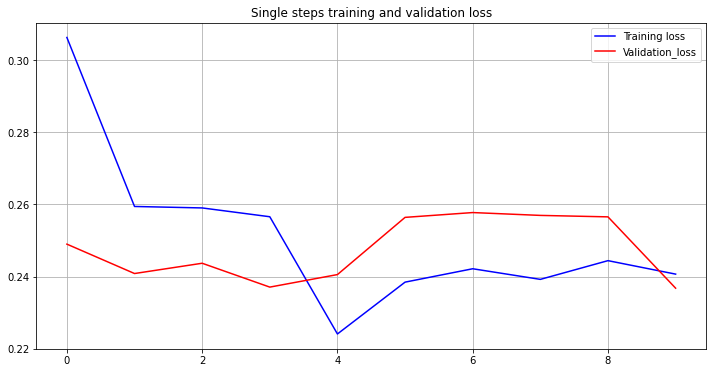

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [56]:
# plot the training and validation losses
def plot_losses(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation_loss')

    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()
    
    return plt


plot_losses(single_steps_history, 'Single steps training and validation loss')

8/8 [==============================] - 0s 4ms/step


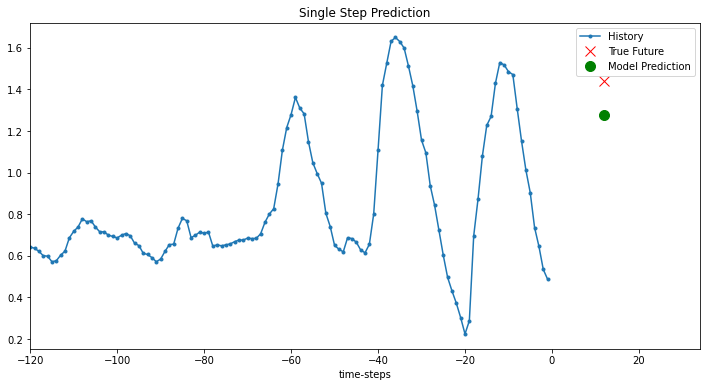

8/8 [==============================] - 0s 4ms/step


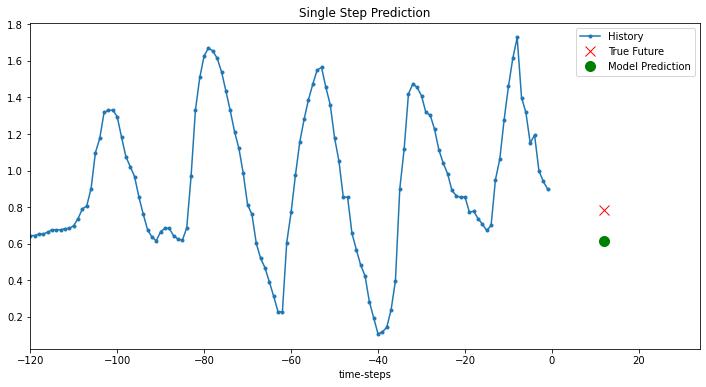

8/8 [==============================] - 0s 4ms/step


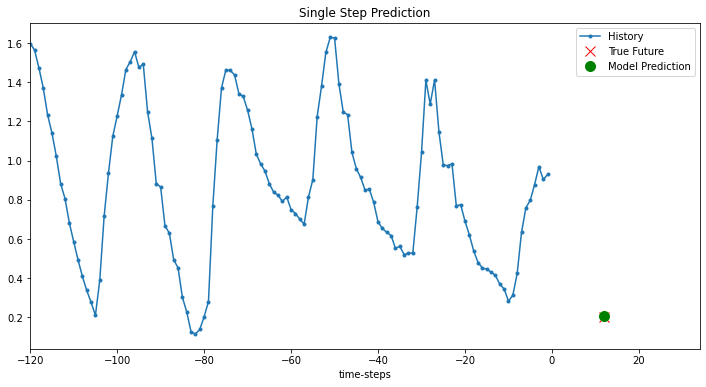

8/8 [==============================] - 0s 4ms/step


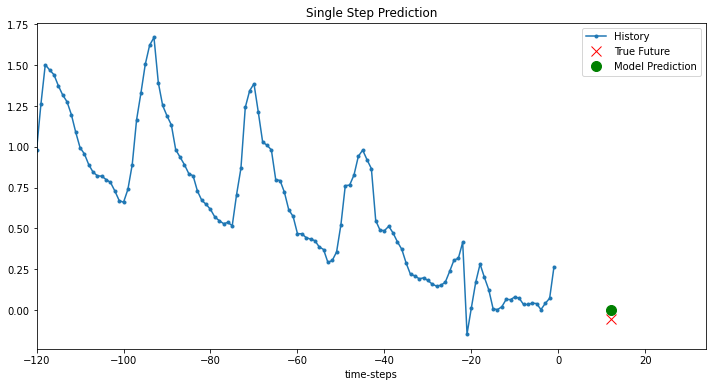

8/8 [==============================] - 0s 4ms/step


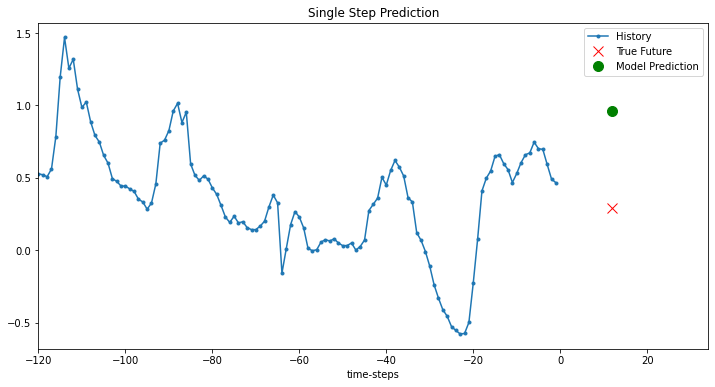

In [57]:
# plotting the predicted value
for x, y in val_data_single.take(5):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_steps_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

# Multi-variate and multi-steps forecasting(multiple-output):

In [58]:
# setting single_steps is false as default value
future_target = 72 # 72 future values
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,train_split, past_history, future_target, 6)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],train_split, None, past_history, future_target,6)

print(x_train_multi.shape)
print(y_train_multi.shape)
print(x_val_multi.shape)
print(y_val_multi.shape)

(299280, 120, 3)
(299280, 72)
(119759, 120, 3)
(119759, 72)


In [59]:
# tensor data set
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi)) 
val_data_multi = val_data_multi.batch(batch_size).repeat()

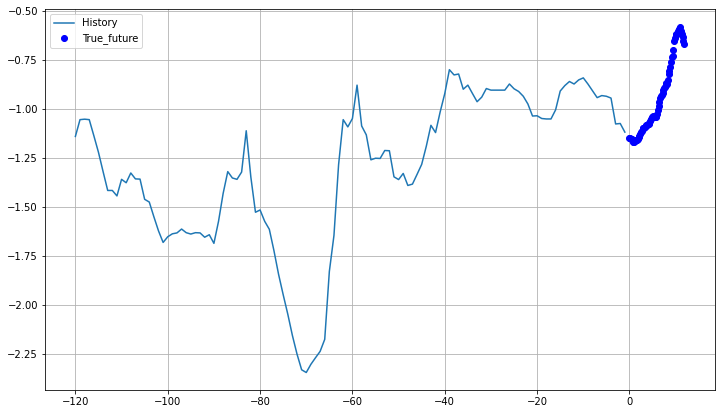

In [60]:
# multi-steps plot
steps = 6

def multi_steps_plot(history, true_future, predicted):
    plt.figure(figsize=(12,7))

    num_in = create_timeSteps(len(history))
    num_out = len(true_future)
    plt.grid()
    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/steps, np.array(true_future), 'bo', label='True_future')

    if predicted.any():
        plt.plot(np.arange(num_out)/steps,np.array(predicted), 'ro', label='Predicted_value')

    plt.legend(loc='upper left')
    plt.show()

    return plt

for x,y in train_data_multi.take(1):
    multi_steps_plot(x[0], y[0], np.array([0]))

In [61]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=x_train_multi.shape[-2:])) # return sequence for next layer
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=Epochs,
                                          steps_per_epoch=Steps_per_epoch,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 47s 223ms/step - loss: 0.4861 - val_loss: 0.3044
Epoch 2/10
200/200 [==============================] - 46s 228ms/step - loss: 0.3245 - val_loss: 0.2525
Epoch 3/10
200/200 [==============================] - 42s 210ms/step - loss: 0.2654 - val_loss: 0.2308
Epoch 4/10
200/200 [==============================] - 44s 219ms/step - loss: 0.2262 - val_loss: 0.2020
Epoch 5/10
200/200 [==============================] - 44s 220ms/step - loss: 0.1937 - val_loss: 0.1949
Epoch 6/10
200/200 [==============================] - 44s 218ms/step - loss: 0.2024 - val_loss: 0.2125
Epoch 7/10
200/200 [==============================] - 46s 231ms/step - loss: 0.1967 - val_loss: 0.2235
Epoch 8/10
200/200 [==============================] - 42s 211ms/step - loss: 0.1921 - val_loss: 0.1850
Epoch 9/10
200/200 [==============================] - 44s 219ms/step - loss: 0.1959 - val_loss: 0.2014
Epoch 10/10
200/200 [==============================] - 44s 222ms/step - l

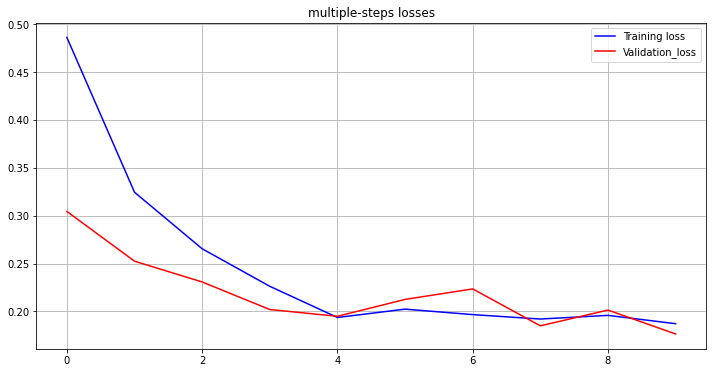

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [62]:
plot_losses(multi_step_history, 'multiple-steps losses')

8/8 [==============================] - 2s 64ms/step


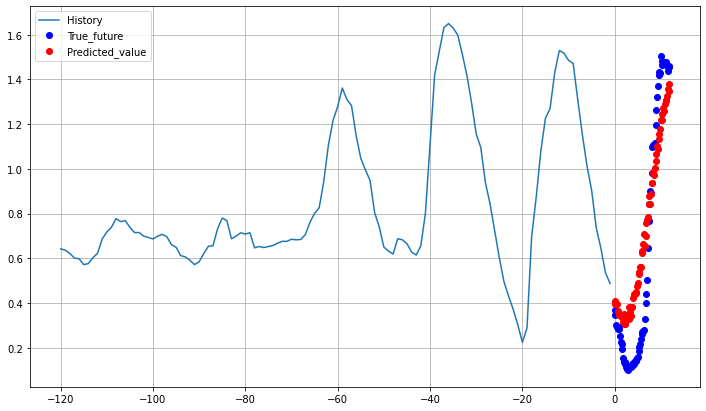

8/8 [==============================] - 0s 18ms/step


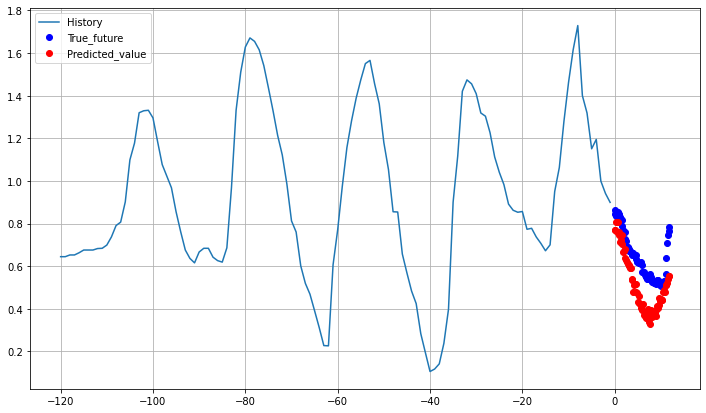

8/8 [==============================] - 0s 18ms/step


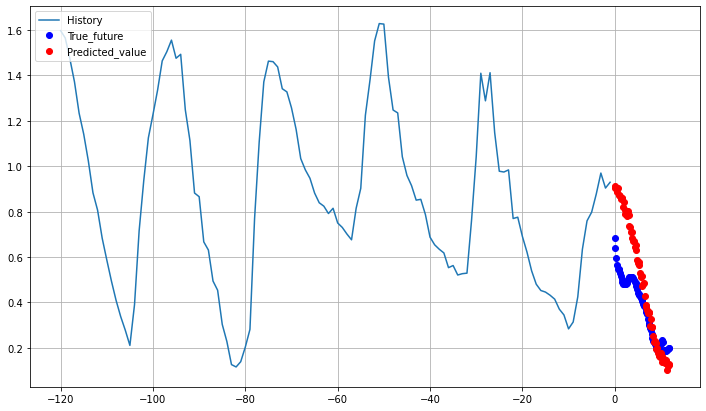

8/8 [==============================] - 0s 19ms/step


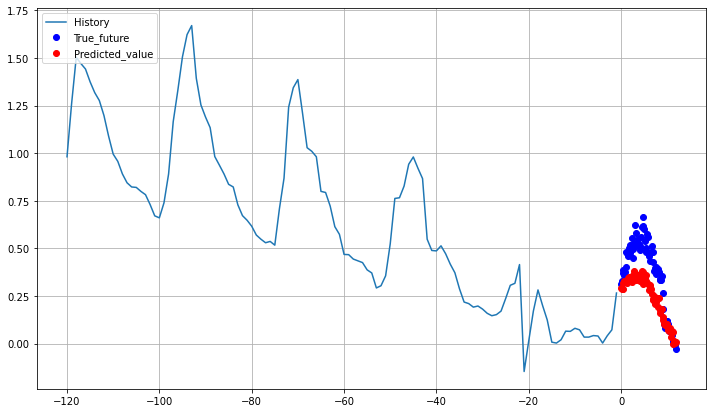

8/8 [==============================] - 0s 19ms/step


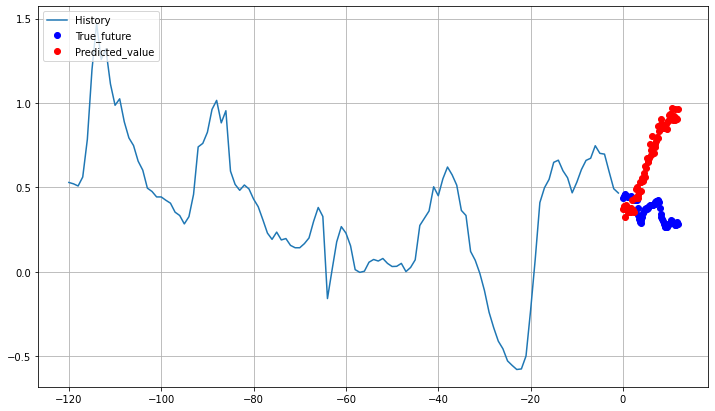

In [63]:
for x,y in val_data_multi.take(5):
    multi_steps_plot(x[0], y[0], multi_step_model.predict(x)[0])